In [1]:
# see http://pytorch.org/tutorials/beginner/nlp/word_embeddings_tutorial.html
import torch
from torch.autograd import Variable
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

torch.manual_seed(1)

In [2]:
CONTEXT_SIZE = 2  # 2 words to the left, 2 to the right
text = """We are about to study the idea of a computational process.
Computational processes are abstract beings that inhabit computers.
As they evolve, processes manipulate other abstract things called data.
The evolution of a process is directed by a pattern of rules
called a program. People create programs to direct processes. In effect,
we conjure the spirits of the computer with our spells.""".split()

split_ind = (int)(len(text) * 0.8)

# By deriving a set from `raw_text`, we deduplicate the array
vocab = set(text)
vocab_size = len(vocab)
print('vocab_size:', vocab_size)

w2i = {w: i for i, w in enumerate(vocab)}
i2w = {i: w for i, w in enumerate(vocab)}

vocab_size: 49


In [3]:
# context window size is two
def create_cbow_dataset(text):
    data = []
    for i in range(2, len(text) - 2):
        context = [text[i - 2], text[i - 1],
                   text[i + 1], text[i + 2]]
        target = text[i]
        data.append((context, target))
    return data

def create_skipgram_dataset(text):
    import random
    data = []
    for i in range(2, len(text) - 2):
        data.append((text[i], text[i-2], 1))
        data.append((text[i], text[i-1], 1))
        data.append((text[i], text[i+1], 1))
        data.append((text[i], text[i+2], 1))
        # negative sampling
        for _ in range(4):
            if random.random() < 0.5 or i >= len(text) - 3:
                rand_id = random.randint(0, i-1)
            else:
                rand_id = random.randint(i+3, len(text)-1)
            data.append((text[i], text[rand_id], 0))
    return data

cbow_train = create_cbow_dataset(text)
skipgram_train = create_skipgram_dataset(text)
print('cbow sample', cbow_train[0])
print('skipgram sample', skipgram_train[0])

cbow sample (['We', 'are', 'to', 'study'], 'about')
skipgram sample ('about', 'We', 1)


In [4]:
class CBOW(nn.Module):
    def __init__(self, vocab_size, embd_size, context_size, hidden_size):
        super(CBOW, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
        self.linear1 = nn.Linear(2*context_size*embd_size, hidden_size)
        self.linear2 = nn.Linear(hidden_size, vocab_size)
        
    def forward(self, inputs):
        embedded = self.embeddings(inputs).view((1, -1))
        hid = F.relu(self.linear1(embedded))
        out = self.linear2(hid)
        log_probs = F.log_softmax(out)
        return log_probs

class SkipGram(nn.Module):
    def __init__(self, vocab_size, embd_size):
        super(SkipGram, self).__init__()
        self.embeddings = nn.Embedding(vocab_size, embd_size)
    
    def forward(self, focus, context):
        embed_focus = self.embeddings(focus).view((1, -1))
        embed_ctx = self.embeddings(context).view((1, -1))
        score = torch.mm(embed_focus, torch.t(embed_ctx))
        log_probs = F.logsigmoid(score)
    
        return log_probs

In [5]:
embd_size = 100
learning_rate = 0.001
n_epoch = 30

def train_cbow():
    hidden_size = 64
    losses = []
    loss_fn = nn.NLLLoss()
    model = CBOW(vocab_size, embd_size, CONTEXT_SIZE, hidden_size)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)

    for epoch in range(n_epoch):
        total_loss = .0
        for context, target in cbow_train:
            ctx_idxs = [w2i[w] for w in context]
            ctx_var = Variable(torch.LongTensor(ctx_idxs))

            model.zero_grad()
            log_probs = model(ctx_var)

            loss = loss_fn(log_probs, Variable(torch.LongTensor([w2i[target]])))

            loss.backward()
            optimizer.step()

            total_loss += loss.data[0]
        losses.append(total_loss)
    return model, losses

def train_skipgram():
    losses = []
    loss_fn = nn.MSELoss()
    model = SkipGram(vocab_size, embd_size)
    print(model)
    optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    
    for epoch in range(n_epoch):
        total_loss = .0
        for in_w, out_w, target in skipgram_train:
            in_w_var = Variable(torch.LongTensor([w2i[in_w]]))
            out_w_var = Variable(torch.LongTensor([w2i[out_w]]))
            
            model.zero_grad()
            log_probs = model(in_w_var, out_w_var)
            loss = loss_fn(log_probs[0], Variable(torch.Tensor([target])))
            
            loss.backward()
            optimizer.step()

            total_loss += loss.data[0]
        losses.append(total_loss)
    return model, losses
    
cbow_model, cbow_losses = train_cbow()
sg_model, sg_losses = train_skipgram()

CBOW (
  (embeddings): Embedding(49, 100)
  (linear1): Linear (400 -> 64)
  (linear2): Linear (64 -> 49)
)
SkipGram (
  (embeddings): Embedding(49, 100)
)


In [7]:
# test
# You have to use other dataset for test, but in this case I use training data because this dataset is too small
def test_cbow(test_data, model):
    print('====Test CBOW===')
    correct_ct = 0
    for ctx, target in test_data:
        ctx_idxs = [w2i[w] for w in ctx]
        ctx_var = Variable(torch.LongTensor(ctx_idxs))

        model.zero_grad()
        log_probs = model(ctx_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted_word = i2w[predicted[0]]
        print('predicted:', predicted_word)
        print('label    :', target)
        if predicted_word == target:
            correct_ct += 1
            
    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

def test_skipgram(test_data, model):
    print('====Test SkipGram===')
    correct_ct = 0
    for in_w, out_w, target in test_data:
        in_w_var = Variable(torch.LongTensor([w2i[in_w]]))
        out_w_var = Variable(torch.LongTensor([w2i[out_w]]))

        model.zero_grad()
        log_probs = model(in_w_var, out_w_var)
        _, predicted = torch.max(log_probs.data, 1)
        predicted = predicted[0]
        if predicted == target:
            correct_ct += 1

    print('Accuracy: {:.1f}% ({:d}/{:d})'.format(correct_ct/len(test_data)*100, correct_ct, len(test_data)))

test_cbow(cbow_train, cbow_model)
print('------')
test_skipgram(skipgram_train, sg_model)

====Test CBOW===
predicted: about
label    : about
predicted: to
label    : to
predicted: study
label    : study
predicted: the
label    : the
predicted: idea
label    : idea
predicted: of
label    : of
predicted: a
label    : a
predicted: computational
label    : computational
predicted: process.
label    : process.
predicted: Computational
label    : Computational
predicted: processes
label    : processes
predicted: are
label    : are
predicted: abstract
label    : abstract
predicted: beings
label    : beings
predicted: that
label    : that
predicted: inhabit
label    : inhabit
predicted: computers.
label    : computers.
predicted: As
label    : As
predicted: they
label    : they
predicted: evolve,
label    : evolve,
predicted: processes
label    : processes
predicted: manipulate
label    : manipulate
predicted: other
label    : other
predicted: abstract
label    : abstract
predicted: things
label    : things
predicted: called
label    : called
predicted: data.
label    : data.
predi

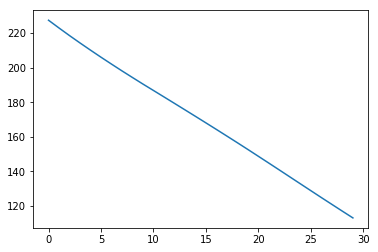

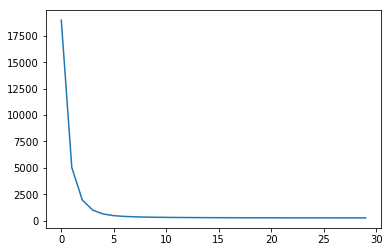

In [8]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np

def showPlot(points, title):
    plt.figure()
    fig, ax = plt.subplots()
    plt.plot(points)

showPlot(cbow_losses, 'CBOW Losses')
showPlot(sg_losses, 'SkipGram Losses')